In [2]:
# Imports
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.visualization import *
from scripts.create_max_separated_matrix import *
from tqdm import tqdm
import os

In [3]:
# load dataset and check class distribution 
data = pd.read_csv("cic-data/Encoded-L7-DstPrt_Cleaned_NF_dataset.csv")
data_cols = data.columns.to_list()
if "Attack" in data_cols:
    data_cols.remove("Attack")
    data_cols.append("Attack")
# reorder columns
data = data[data_cols]

In [4]:
data.columns

Index(['IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS',
       'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS',
       'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT',
       'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN',
       'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'DNS_TTL_ANSWER', 'L4_DST_PORT_21', 'L4_DST_PORT_22', 'L4_DST_PORT_67',
       'L4_DST_PORT_80', 'L4_DST_PORT_443', 'L4_DST_PORT_500',
       'L4_DST_PORT_3306', 'L4_DST_PORT_8080', 'L4_DST_PORT_31808',
       'L4_DST_PORT_OTHERS', 'L7_PROTO_7', 'L7_PROTO_79', 'L7_PROTO_92',
       'L7_PROTO_131', 'L7_PROTO_178', 'L7_PROTO_OTHERS', 'Attack'],
      dtype='object')

In [4]:
INT2LABEL = {0: 'Benign',
 1: 'Bot',
 2: 'Brute Force -Web',
 3: 'Brute Force -XSS',
 4: 'DDOS attack-HOIC',
 5: 'DDOS attack-LOIC-UDP',
 6: 'DDoS attacks-LOIC-HTTP',
 7: 'DoS attacks-GoldenEye',
 8: 'DoS attacks-Hulk',
 9: 'DoS attacks-SlowHTTPTest',
 10: 'DoS attacks-Slowloris',
 11: 'FTP-BruteForce',
 12: 'Infilteration',
 13: 'SQL Injection',
 14: 'SSH-Bruteforce'
}

In [5]:
data["Attack"] = data["Attack"].map(lambda x: INT2LABEL[x])
data["Attack"].value_counts()

Attack
Benign                      1728478
DoS attacks-Hulk             324182
DDOS attack-HOIC              98985
DoS attacks-GoldenEye         27167
Infilteration                 27046
DDoS attacks-LOIC-HTTP        17171
SSH-Bruteforce                15014
DDOS attack-LOIC-UDP           2108
Brute Force -Web               1594
Brute Force -XSS                819
Bot                             632
SQL Injection                   354
DoS attacks-Slowloris           266
FTP-BruteForce                   47
DoS attacks-SlowHTTPTest         35
Name: count, dtype: int64

In [6]:
# encode labels using label encoder and create a dictionary to map labels to integers
scaler = StandardScaler()
data.iloc[:, :-2] = scaler.fit_transform(data.iloc[:, :-2])

In [7]:
# compute class weights
from sklearn.utils import class_weight
CLASS_WEIGHTS = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(data["label"]), y=data["label"])
print(f"Class weights: {CLASS_WEIGHTS}")

Class weights: [8.65461984e-02 2.36698101e+02 9.38476788e+01 1.82653480e+02
 1.51127140e+00 7.09645161e+01 8.71196785e+00 5.50643060e+00
 4.61448199e-01 4.27409143e+03 5.62380451e+02 3.18283404e+03
 5.53106559e+00 4.22579661e+02 9.96358066e+00]


In [8]:
CLASS_NAMES

['Benign',
 'Bot',
 'Brute Force -Web',
 'Brute Force -XSS',
 'DDOS attack-HOIC',
 'DDOS attack-LOIC-UDP',
 'DDoS attacks-LOIC-HTTP',
 'DoS attacks-GoldenEye',
 'DoS attacks-Hulk',
 'DoS attacks-SlowHTTPTest',
 'DoS attacks-Slowloris',
 'FTP-BruteForce',
 'Infilteration',
 'SQL Injection',
 'SSH-Bruteforce']

In [9]:
# standard scale the data, without Attack or label column
scaler = StandardScaler()
data.iloc[:, :-2] = scaler.fit_transform(data.iloc[:, :-2])

In [10]:
class CICDataset(Dataset):

    def __init__(self, data, transform=None):
        self.transform = transform
        self.labels = data["label"].values.astype(np.int64)
        self.data = data.drop(columns=["Attack"]) #.values.astype(np.float32)
        # check if attack in data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.data.iloc[idx, :-1]
        label = self.labels[idx]
        
        sample = torch.tensor(sample, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.int64)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, label

In [11]:
# split into train, val and test sets
# split into 80, 10, 10 with stratification
# random seed for reproducibility

seed = 369
train, test = train_test_split(data, test_size=0.2, stratify=data["label"], random_state=seed)
val, test = train_test_split(test, test_size=0.5, stratify=test["label"], random_state=seed)

# create datasets
train_dataset = CICDataset(train)
val_dataset = CICDataset(val)
test_dataset = CICDataset(test)

In [12]:
# create dataloaders, pin memory for faster transfer to GPU
BATCH_SIZE = 64
num_workers = 10
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

In [13]:
# create model 

class MLP(nn.Module):
    """Simple MLP with 3 hidden layers, and batch normalization after each"""
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        return self.fc3(self.relu(self.bn2(self.fc2(self.relu(self.bn1(self.fc1(x)))))))

In [14]:
input_size = train_dataset[0][0].shape[0]
hidden_size = 128
output_size = len(CLASS_NAMES)-1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [15]:
torch.cuda.empty_cache()

In [16]:
# calculate max separated matrix
r = 1.0
INDEX_BIAS = create_prototypes(output_size+1)
INDEX_BIAS = torch.from_numpy(INDEX_BIAS).float()
INDEX_BIAS *= r
INDEX_BIAS = INDEX_BIAS.t().to(device)

In [17]:
# set hyperparameters, device, loss function and optimizer

model = MLP(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(CLASS_WEIGHTS).float()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS=10

In [18]:
from tqdm.notebook import tqdm 
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs, save_path="weights/model.pt"):
    train_losses = []
    val_losses = []
    train_preds = []
    train_labels = []
    val_preds = []
    val_labels = []
    best_val_loss = np.inf
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    epoch_pbar = tqdm(total=num_epochs, desc="Epoch Progress")

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        model.train()

        train_pbar = tqdm(train_dataloader, desc="Training Batch Progress", leave=False)
        for batch in train_pbar:
            inputs, labels = batch
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = torch.mm(outputs, INDEX_BIAS)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)

            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            train_pbar.set_postfix({"Batch Train Loss": f"{loss.item():.4f}"})

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        val_loss = 0
        val_acc = 0
        model.eval()

        val_pbar = tqdm(val_dataloader, desc="Validation Batch Progress", leave=False)
        with torch.no_grad():
            for batch in val_pbar:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                outputs = torch.mm(outputs, INDEX_BIAS)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data)

                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
                val_pbar.set_postfix({"Batch Val Loss": f"{loss.item():.4f}"})

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        epoch_pbar.update(1)
        epoch_pbar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

        if val_loss < best_val_loss:
            if not os.path.exists(os.path.dirname(save_path)):
                os.makedirs(os.path.dirname(save_path))
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)

    epoch_pbar.close()
    return train_losses, val_losses, train_preds, train_labels, val_preds, val_labels

In [17]:
# test training

train_losses, val_losses, train_preds, train_labels, val_preds, val_labels = train_model(model, criterion, optimizer, train_dataloader, val_dataloader, EPOCHS)

Epoch Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

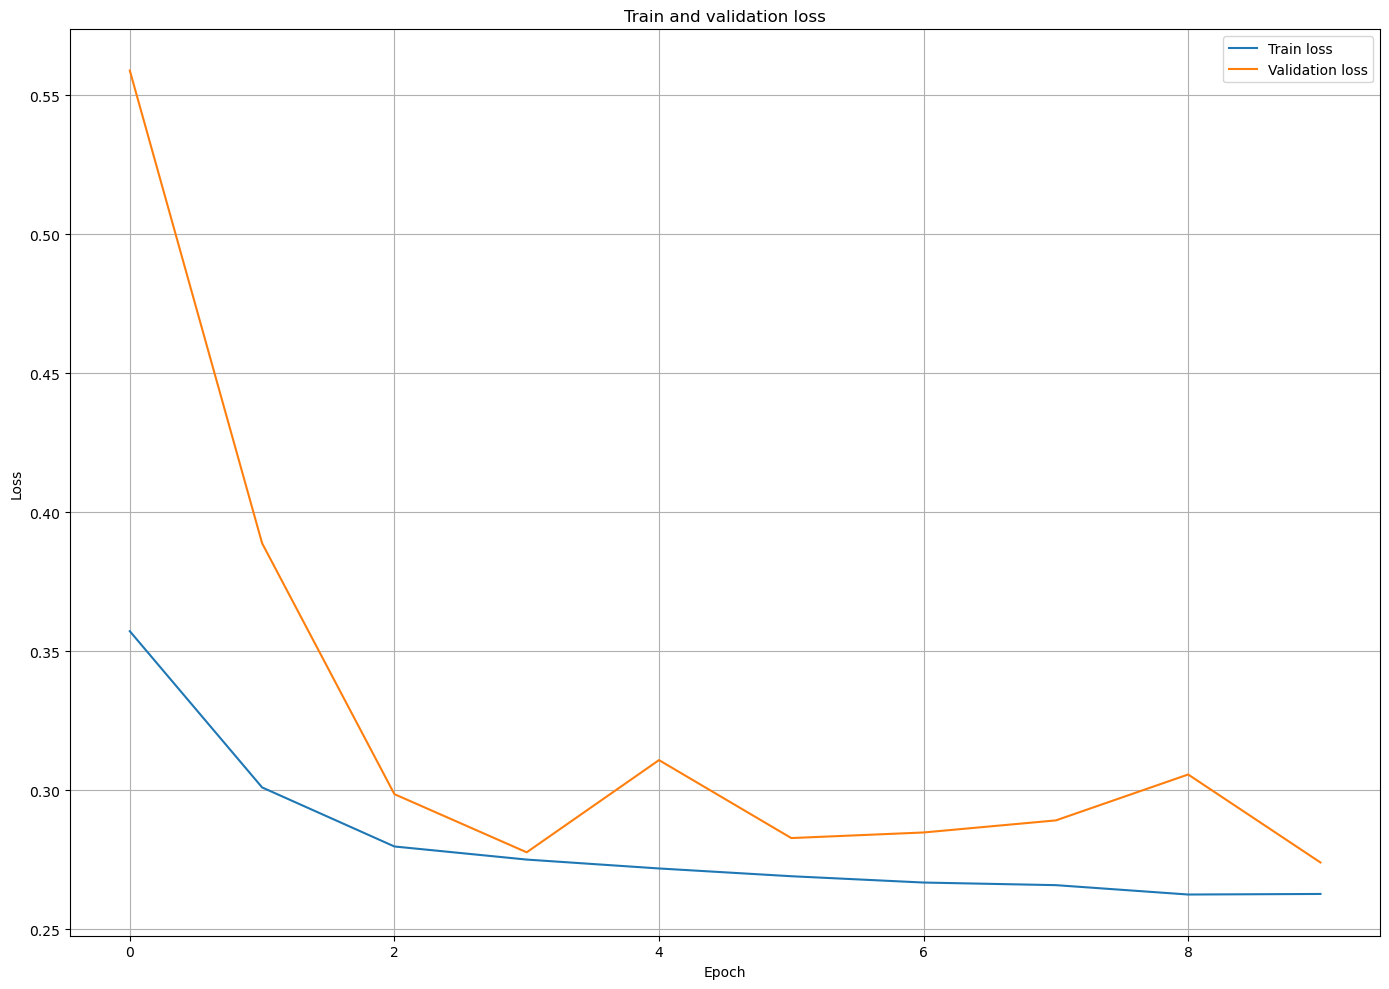

In [18]:
# plot training and validation losses
plot_train_validation_loss(train_losses, val_losses)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(train_labels, train_preds, target_names=CLASS_NAMES))

                          precision    recall  f1-score   support

                  Benign       1.00      0.83      0.90  13827820
                     Bot       0.82      1.00      0.90      5060
        Brute Force -Web       0.06      0.17      0.09     12750
        Brute Force -XSS       0.19      0.14      0.16      6550
        DDOS attack-HOIC       0.97      0.96      0.97    791880
    DDOS attack-LOIC-UDP       0.97      0.97      0.97     16860
  DDoS attacks-LOIC-HTTP       0.91      1.00      0.95    137370
   DoS attacks-GoldenEye       0.88      0.98      0.93    217340
        DoS attacks-Hulk       1.00      0.99      0.99   2593450
DoS attacks-SlowHTTPTest       0.12      0.41      0.18       280
   DoS attacks-Slowloris       0.33      0.95      0.49      2130
          FTP-BruteForce       0.18      0.63      0.28       380
           Infilteration       0.07      0.80      0.13    216370
           SQL Injection       0.02      0.10      0.03      2830
         

In [20]:
print(classification_report(val_labels, val_preds, target_names=CLASS_NAMES))

                          precision    recall  f1-score   support

                  Benign       1.00      0.85      0.92   1728480
                     Bot       0.69      1.00      0.82       630
        Brute Force -Web       0.08      0.12      0.09      1590
        Brute Force -XSS       0.14      0.10      0.11       820
        DDOS attack-HOIC       0.97      0.99      0.98     98990
    DDOS attack-LOIC-UDP       0.98      0.97      0.97      2110
  DDoS attacks-LOIC-HTTP       0.96      1.00      0.98     17170
   DoS attacks-GoldenEye       0.99      0.84      0.91     27160
        DoS attacks-Hulk       0.99      1.00      0.99    324190
DoS attacks-SlowHTTPTest       0.08      0.45      0.14        40
   DoS attacks-Slowloris       0.37      0.96      0.54       260
          FTP-BruteForce       0.17      0.60      0.27        50
           Infilteration       0.08      0.78      0.14     27050
           SQL Injection       0.01      0.04      0.02       350
         

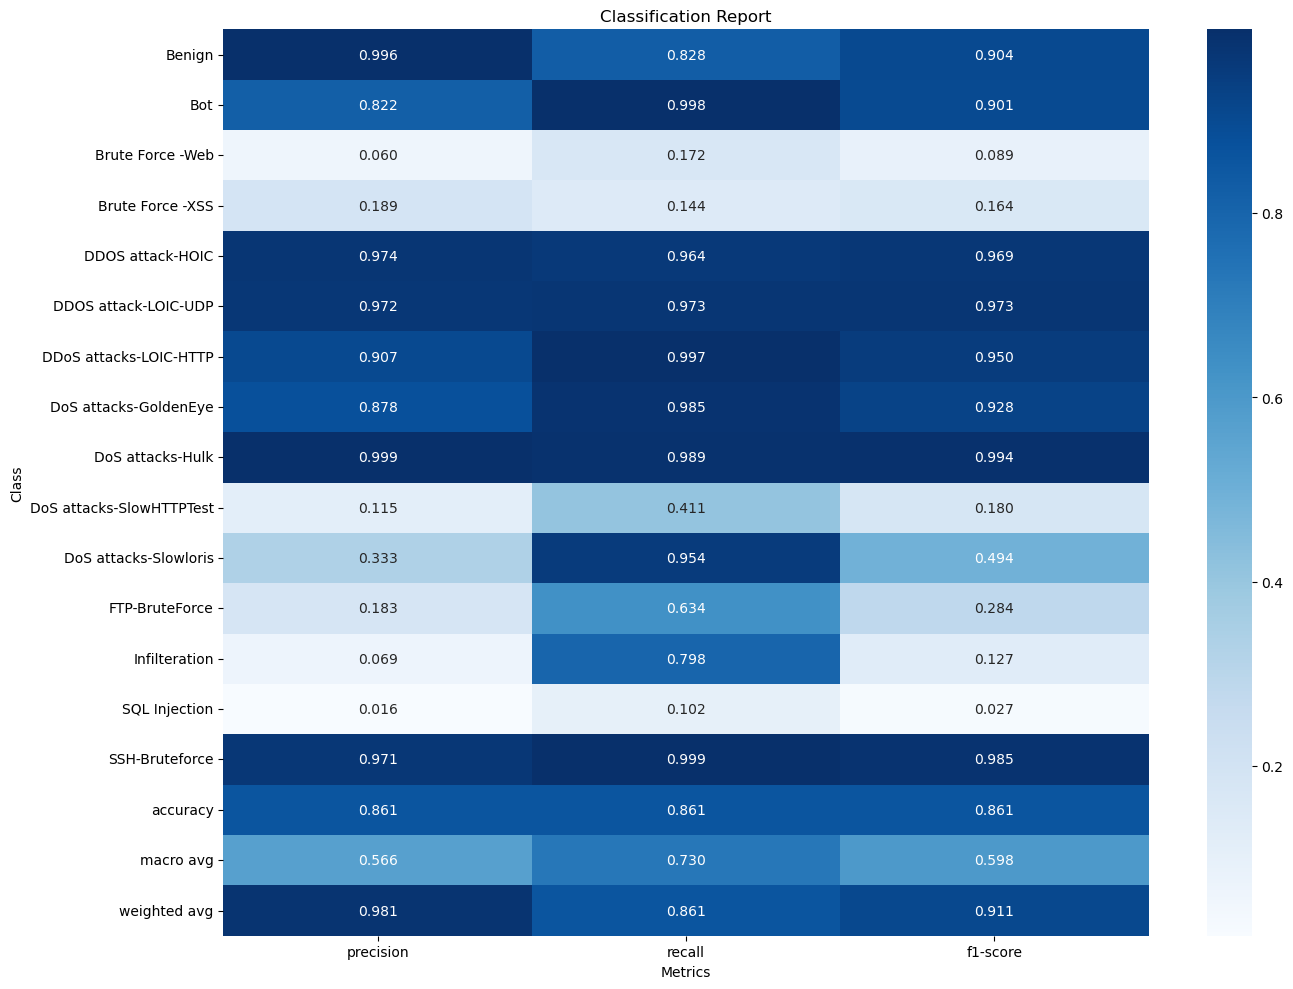

In [21]:
plot_classification_report(train_labels, train_preds, CLASS_NAMES)

In [25]:
# evaluate on test set

model.load_state_dict(torch.load("weights/model.pt"))
model.eval()

test_preds = []
test_labels = []
test_loss = 0
test_acc = 0
test_pbar = tqdm(test_dataloader, desc="Test Batch Progress", leave=False)
with torch.no_grad():
    for batch in test_pbar:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        outputs = torch.mm(outputs, INDEX_BIAS)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels.data)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        test_pbar.set_postfix({"Batch Test Loss": f"{loss.item():.4f}"})

test_loss /= len(test_dataloader)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc/len(test_dataset):.4f}")


Test Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Test Loss: 0.2775
Test Accuracy: 0.8807


In [26]:
print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES))


                          precision    recall  f1-score   support

                  Benign       1.00      0.85      0.92    172848
                     Bot       0.94      1.00      0.97        63
        Brute Force -Web       0.50      0.04      0.08       160
        Brute Force -XSS       0.11      0.13      0.12        82
        DDOS attack-HOIC       0.97      1.00      0.99      9898
    DDOS attack-LOIC-UDP       0.99      0.99      0.99       211
  DDoS attacks-LOIC-HTTP       0.97      1.00      0.98      1717
   DoS attacks-GoldenEye       0.99      1.00      0.99      2717
        DoS attacks-Hulk       1.00      1.00      1.00     32418
DoS attacks-SlowHTTPTest       0.00      0.00      0.00         3
   DoS attacks-Slowloris       0.44      1.00      0.61        27
          FTP-BruteForce       0.57      1.00      0.73         4
           Infilteration       0.08      0.79      0.14      2704
           SQL Injection       0.03      0.11      0.05        36
         

In [27]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'data' is a pandas DataFrame and 'Attack' is your target column
X = data.drop(columns=["Attack", "label"]).values
y = data['label'].values
# Convert to PyTorch tensors
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).long()

# Create a DataLoader
batch_size = 1024  # You can set a different batch size if you want
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True)


# add hook for model 2nd last layer
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

model.fc2.register_forward_hook(get_features('fc2'))

outputs_list = []
labels_list = []

with torch.no_grad():
    for inputs, labels in tqdm(dataloader, desc="Batch Progress", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model(inputs)
        
        outputs_list.append(features["fc2"].cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Convert to NumPy arrays
outputs_array = np.concatenate(outputs_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

# Save to NPZ file
np.savez('features/base_model_outputs_and_labels.npz', outputs=outputs_array, labels=labels_array)


Batch Progress:   0%|          | 0/2192 [00:00<?, ?it/s]

In [19]:
# combine index bias and focal loss
from focal_loss.focal_loss import FocalLoss


In [20]:
from tqdm.notebook import tqdm 
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs, save_path="weights/model.pt"):
    train_losses = []
    val_losses = []
    train_preds = []
    train_labels = []
    val_preds = []
    val_labels = []
    best_val_loss = np.inf
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    epoch_pbar = tqdm(total=num_epochs, desc="Epoch Progress")

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        model.train()

        train_pbar = tqdm(train_dataloader, desc="Training Batch Progress", leave=False)
        for batch in train_pbar:
            inputs, labels = batch
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = torch.mm(outputs, INDEX_BIAS)
            loss = criterion(m(outputs), labels)
            # loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)

            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            train_pbar.set_postfix({"Batch Train Loss": f"{loss.item():.4f}"})

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        val_loss = 0
        val_acc = 0
        model.eval()

        val_pbar = tqdm(val_dataloader, desc="Validation Batch Progress", leave=False)
        with torch.no_grad():
            for batch in val_pbar:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                outputs = torch.mm(outputs, INDEX_BIAS)
                loss = criterion(m(outputs), labels)
                # loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data)

                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
                val_pbar.set_postfix({"Batch Val Loss": f"{loss.item():.4f}"})

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        epoch_pbar.update(1)
        epoch_pbar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

        if val_loss < best_val_loss:
            if not os.path.exists(os.path.dirname(save_path)):
                os.makedirs(os.path.dirname(save_path))
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)

    epoch_pbar.close()
    return train_losses, val_losses, train_preds, train_labels, val_preds, val_labels

In [23]:
# create model and train with focal loss and index bias 
GAMMA=1.5
focal_loss_model = MLP(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(focal_loss_model.parameters(), lr=0.001)
EPOCHS=10
m = torch.nn.Softmax(dim=-1)
criterion = FocalLoss(gamma=GAMMA, weights=torch.tensor(CLASS_WEIGHTS).float().to(device)).to(device) # , ignore_index=0
INDEX_BIAS = INDEX_BIAS.to(device)

In [24]:
# train with focal loss
train_losses, val_losses, train_preds, train_labels, val_preds, val_labels = train_model(focal_loss_model, criterion, optimizer, train_dataloader, val_dataloader, EPOCHS, save_path="weights/focal_loss_model.pt")

Epoch Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Training Batch Progress:   0%|          | 0/28049 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

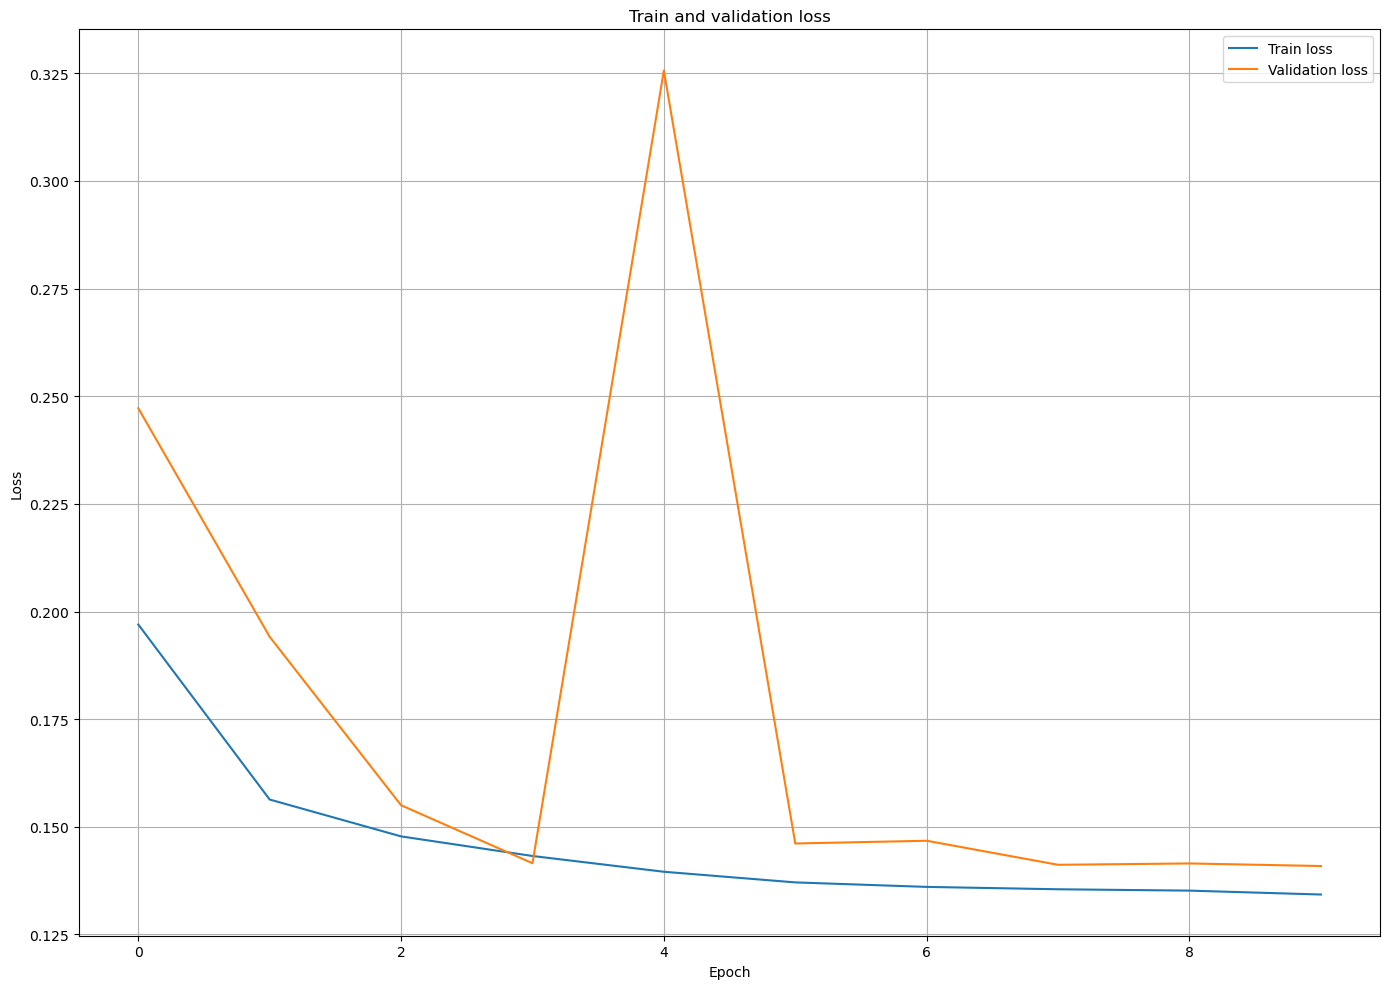

In [25]:
# plot training and validation losses
plot_train_validation_loss(train_losses, val_losses)

In [26]:
print(classification_report(train_labels, train_preds, target_names=CLASS_NAMES))

                          precision    recall  f1-score   support

                  Benign       1.00      0.82      0.90  13827820
                     Bot       0.83      1.00      0.91      5060
        Brute Force -Web       0.06      0.17      0.09     12750
        Brute Force -XSS       0.19      0.14      0.16      6550
        DDOS attack-HOIC       0.97      0.96      0.97    791880
    DDOS attack-LOIC-UDP       0.97      0.97      0.97     16860
  DDoS attacks-LOIC-HTTP       0.90      1.00      0.95    137370
   DoS attacks-GoldenEye       0.86      0.98      0.92    217340
        DoS attacks-Hulk       1.00      0.99      0.99   2593450
DoS attacks-SlowHTTPTest       0.11      0.41      0.17       280
   DoS attacks-Slowloris       0.33      0.94      0.49      2130
          FTP-BruteForce       0.14      0.58      0.23       380
           Infilteration       0.07      0.79      0.12    216370
           SQL Injection       0.01      0.10      0.03      2830
         

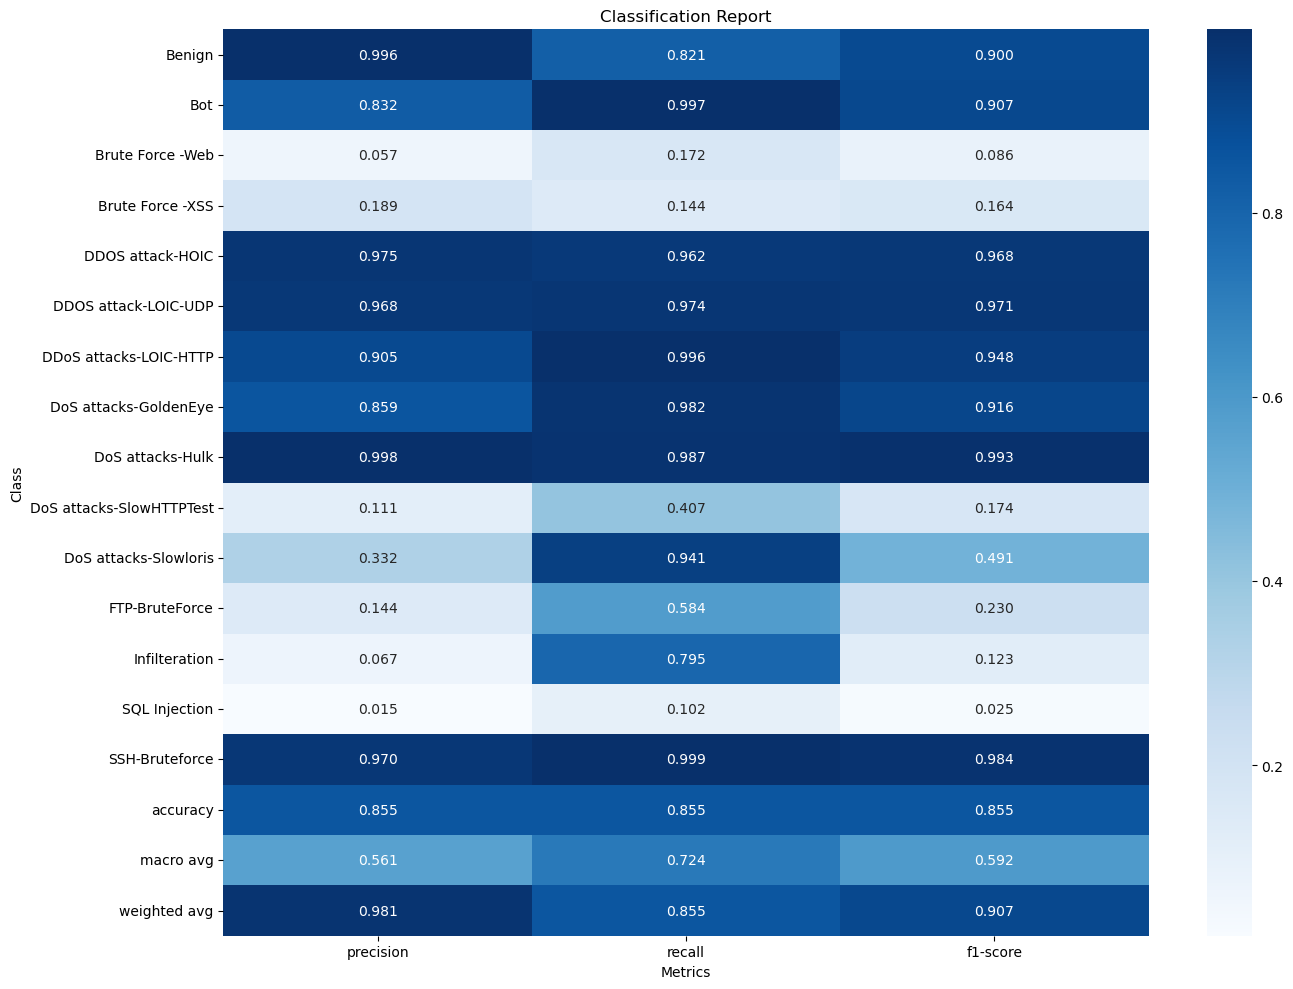

In [27]:
plot_classification_report(train_labels, train_preds, CLASS_NAMES)

In [28]:
# evaluate on test set

focal_loss_model.load_state_dict(torch.load("weights/focal_loss_model.pt"))
focal_loss_model.eval()

test_preds = []
test_labels = []
test_loss = 0
test_acc = 0
test_pbar = tqdm(test_dataloader, desc="Test Batch Progress", leave=False)
with torch.no_grad():
    for batch in test_pbar:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = focal_loss_model(inputs)
        outputs = torch.mm(outputs, INDEX_BIAS)
        loss = criterion(m(outputs), labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels.data)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        test_pbar.set_postfix({"Batch Test Loss": f"{loss.item():.4f}"})

test_loss /= len(test_dataloader)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc/len(test_dataset):.4f}")


Test Batch Progress:   0%|          | 0/3507 [00:00<?, ?it/s]

Test Loss: 0.1408
Test Accuracy: 0.8505


In [29]:
print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES))

                          precision    recall  f1-score   support

                  Benign       1.00      0.81      0.89    172848
                     Bot       0.98      1.00      0.99        63
        Brute Force -Web       0.54      0.04      0.08       160
        Brute Force -XSS       0.12      0.13      0.13        82
        DDOS attack-HOIC       0.97      1.00      0.99      9898
    DDOS attack-LOIC-UDP       0.91      0.99      0.95       211
  DDoS attacks-LOIC-HTTP       0.97      1.00      0.99      1717
   DoS attacks-GoldenEye       0.99      1.00      1.00      2717
        DoS attacks-Hulk       1.00      1.00      1.00     32418
DoS attacks-SlowHTTPTest       0.00      0.00      0.00         3
   DoS attacks-Slowloris       0.47      1.00      0.64        27
          FTP-BruteForce       0.40      1.00      0.57         4
           Infilteration       0.06      0.82      0.12      2704
           SQL Injection       1.00      0.08      0.15        36
         

/home/g6/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g6/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g6/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming 'data' is a pandas DataFrame and 'Attack' is your target column
X = data.drop(columns=["Attack", "label"]).values
y = data['label'].values
# Convert to PyTorch tensors
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).long()

# Create a DataLoader
batch_size = 1024  # You can set a different batch size if you want
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True)


# add hook for model 2nd last layer
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

focal_loss_model.fc2.register_forward_hook(get_features('fc2'))

outputs_list = []
labels_list = []

with torch.no_grad():
    for inputs, labels in tqdm(dataloader, desc="Batch Progress", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = focal_loss_model(inputs)
        
        outputs_list.append(features["fc2"].cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Convert to NumPy arrays
outputs_array = np.concatenate(outputs_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

# Save to NPZ file
np.savez('features/focal_loss_maximum_index_model_outputs_and_labels.npz', outputs=outputs_array, labels=labels_array)


Batch Progress:   0%|          | 0/2192 [00:00<?, ?it/s]